In [387]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


# import chart_studio.plotly as py
# from plotly.offline import iplot, init_notebook_mode
# import cufflinks
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

### Data Loading and Exploration

In [388]:
# Load Data
df = pd.read_csv('Telangana.csv')

print("\n=== Data Info ===")
df.info()
print("\n=== Missing Values ===")
print(df.isnull().sum())
print("\n=== Statistical Summary ===")
print(df.describe())
df.head()



=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   From Date  8760 non-null   object 
 1   To Date    8760 non-null   object 
 2   Ozone      6130 non-null   float64
 3   CO         6124 non-null   float64
 4   SO2        6138 non-null   float64
 5   NO2        6141 non-null   float64
 6   PM10       6104 non-null   float64
 7   PM2.5      6103 non-null   float64
 8   State      8760 non-null   object 
 9   City       8760 non-null   object 
 10  Station    8760 non-null   object 
dtypes: float64(6), object(5)
memory usage: 752.9+ KB

=== Missing Values ===
From Date       0
To Date         0
Ozone        2630
CO           2636
SO2          2622
NO2          2619
PM10         2656
PM2.5        2657
State           0
City            0
Station         0
dtype: int64

=== Statistical Summary ===
             Ozone           CO     

From Date           To Date  Ozone    CO    SO2    NO2   PM10  \
0  01-08-2021 00:00  02-08-2021 00:00  10.73  0.80   7.68  59.17  35.24   
1  02-08-2021 00:00  03-08-2021 00:00   7.80  0.12   7.86  37.23  59.63   
2  03-08-2021 00:00  04-08-2021 00:00  11.32  0.33  15.62  15.85  64.41   
3  04-08-2021 00:00  05-08-2021 00:00   7.03  0.29  19.49  13.93  45.94   
4  05-08-2021 00:00  06-08-2021 00:00   7.12  0.29  23.43  15.69  56.57   

   PM2.5      State       City                                      Station  
0   9.76  Telangana  Hyderabad  Bollaram Industrial Area, Hyderabad - TSPCB  
1  18.54  Telangana  Hyderabad  Bollaram Industrial Area, Hyderabad - TSPCB  
2  21.17  Telangana  Hyderabad  Bollaram Industrial Area, Hyderabad - TSPCB  
3  12.65  Telangana  Hyderabad  Bollaram Industrial Area, Hyderabad - TSPCB  
4  16.21  Telangana  Hyderabad  Bollaram Industrial Area, Hyderabad - TSPCB

### Data Preprocessing

In [389]:
# Column Cleaning and Standardization
print("Original columns:", df.columns.tolist())
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
df.columns = df.columns.str.lower().str.replace(' ', '_')
print("Cleaned columns:", df.columns.tolist())

Original columns: ['From Date', 'To Date', 'Ozone', 'CO', 'SO2', 'NO2', 'PM10', 'PM2.5', 'State', 'City', 'Station']
Cleaned columns: ['from_date', 'to_date', 'ozone', 'co', 'so2', 'no2', 'pm10', 'pm2.5', 'state', 'city', 'station']


#### Missing Values Analysis 

In [390]:
def missing_values_table(dataframe):
    """Generate a comprehensive missing values report."""
    mis_val = dataframe.isnull().sum()
    mis_val_percent = 100 * mis_val / len(dataframe)
    
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'}
    )
    
    mis_val_table = mis_val_table[
        mis_val_table.iloc[:, 1] != 0
    ].sort_values('% of Total Values', ascending=False).round(1)
    
    print(f"Your selected dataframe has {dataframe.shape[1]} columns.\n"
          f"There are {mis_val_table.shape[0]} columns that have missing values.")
    
    return mis_val_table

missing_values = missing_values_table(df)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 11 columns.
There are 6 columns that have missing values.


#### Outlier Detection and Analysis

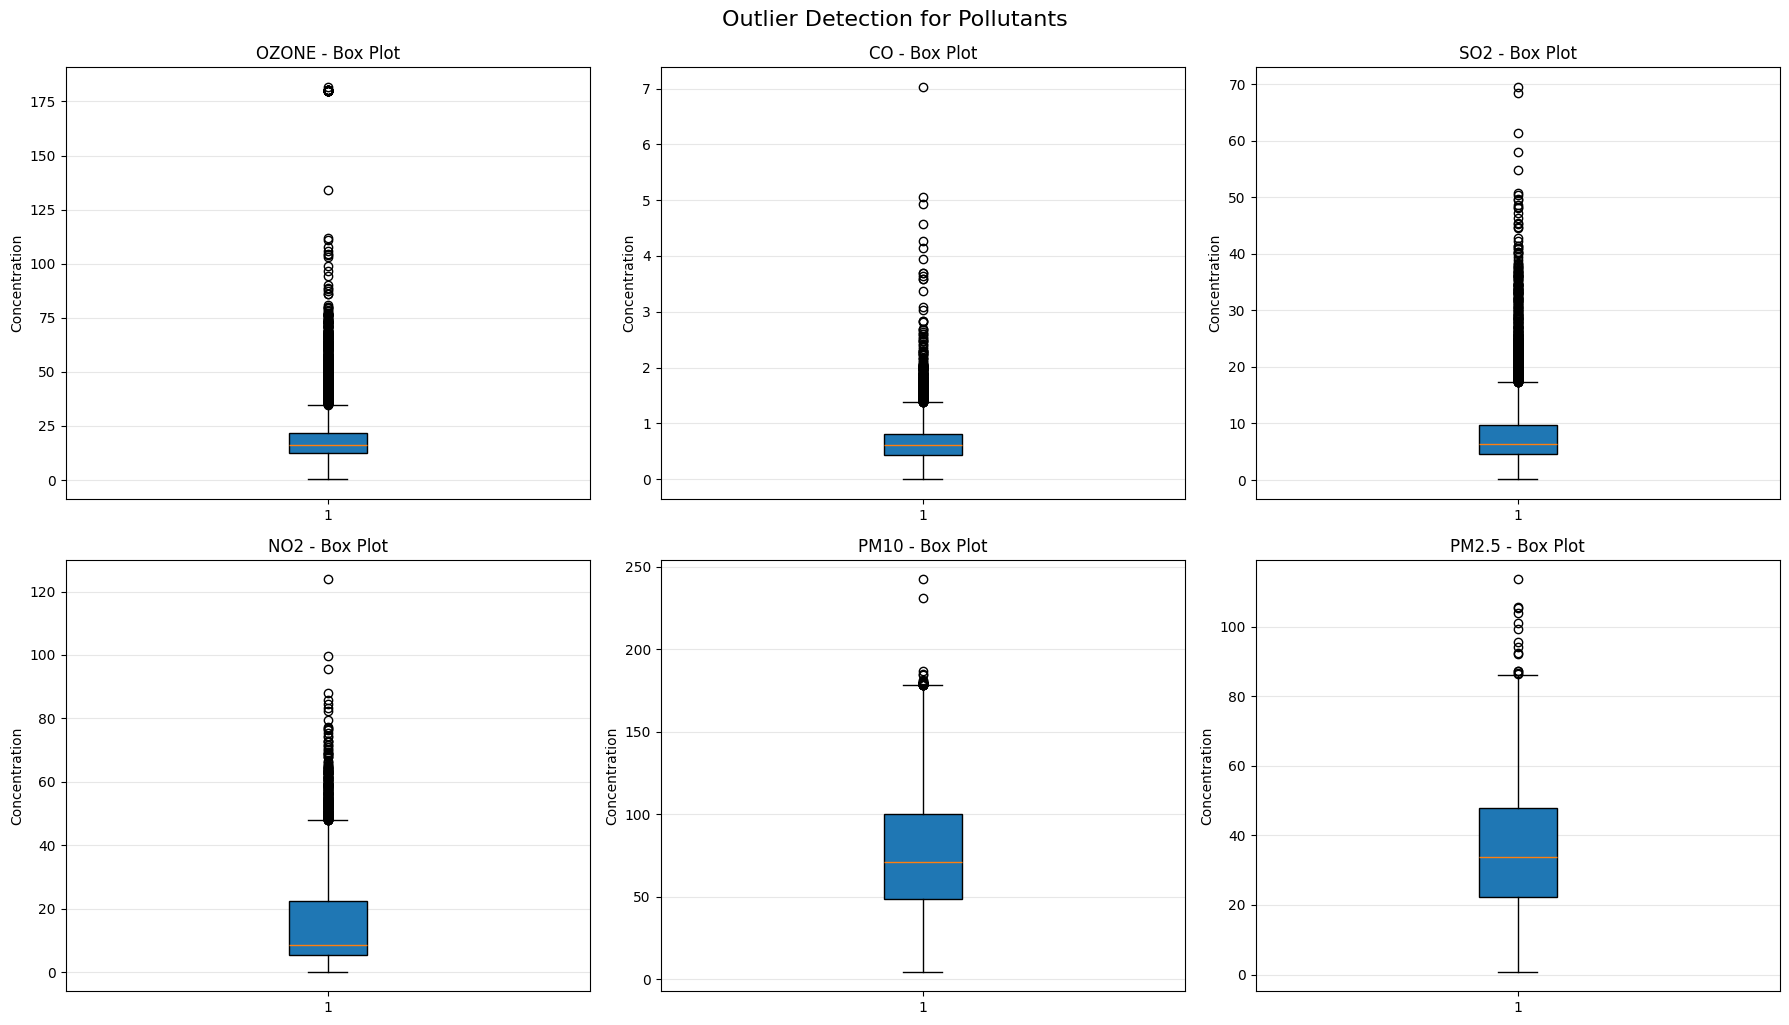

In [391]:
# Check for outliers using box plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

pollutant_cols = ['ozone', 'co', 'so2', 'no2', 'pm10', 'pm2.5']

for i, pollutant in enumerate(pollutant_cols):
    axes[i].boxplot(df[pollutant].dropna(), vert=True, patch_artist=True)
    axes[i].set_title(f'{pollutant.upper()} - Box Plot', fontsize=12)
    axes[i].set_ylabel('Concentration', fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Outlier Detection for Pollutants', fontsize=16, y=1.02)
plt.show()

#### Statistical Summary for Outlier Detection

In [392]:
# Calculate IQR and identify outliers
def detect_outliers(dataframe, columns):
    """
    Detect outliers using IQR method and provide statistics.
    """
    outlier_stats = []
    
    for col in columns:
        data = dataframe[col].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(data)) * 100
        
        outlier_stats.append({
            'Pollutant': col.upper(),
            'Q1': round(Q1, 2),
            'Median': round(data.median(), 2),
            'Q3': round(Q3, 2),
            'IQR': round(IQR, 2),
            'Lower Bound': round(lower_bound, 2),
            'Upper Bound': round(upper_bound, 2),
            'Outlier Count': outlier_count,
            'Outlier %': round(outlier_percentage, 2)
        })
    
    return pd.DataFrame(outlier_stats)

outlier_stats_df = detect_outliers(df, pollutant_cols)
# print("\n=== Outlier Detection Statistics ===")
# print(outlier_stats_df)

# Styled table
outlier_stats_df.style.background_gradient(cmap='YlOrRd', subset=['Outlier %'])

#### Distribution Analysis

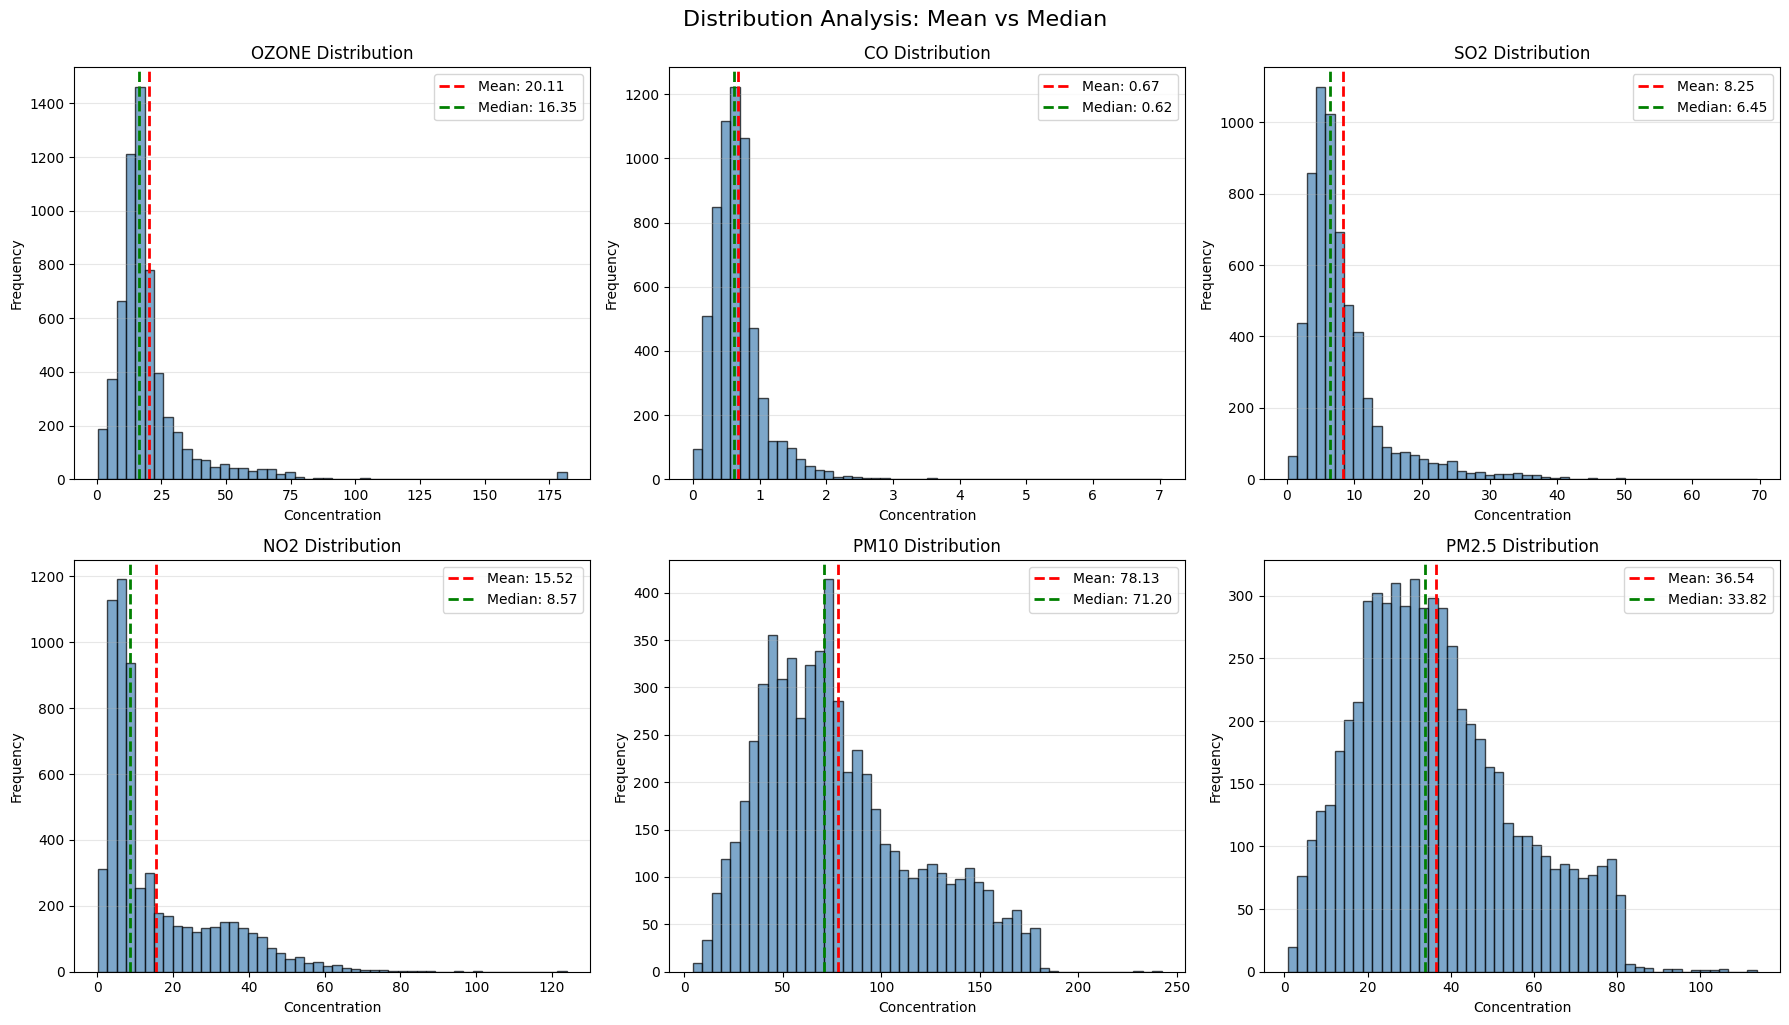

In [393]:
# Plot distributions to understand skewness
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutant_cols):
    data = df[pollutant].dropna()
    
    axes[i].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[i].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[i].set_title(f'{pollutant.upper()} Distribution', fontsize=12)
    axes[i].set_xlabel('Concentration', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend()
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution Analysis: Mean vs Median', fontsize=16, y=1.02)
plt.show()

#### Skewness Analysis

In [394]:
# Calculate skewness to decide between mean and median
from scipy import stats

skewness_data = []
for pollutant in pollutant_cols:
    data = df[pollutant].dropna()
    skew = stats.skew(data)
    
    skewness_data.append({
        'Pollutant': pollutant.upper(),
        'Skewness': round(skew, 3),
        'Interpretation': 'Highly Skewed' if abs(skew) > 1 else ('Moderately Skewed' if abs(skew) > 0.5 else 'Approximately Symmetric'),
        'Recommended Imputation': 'Median' if abs(skew) > 0.5 else 'Mean or Median'
    })

skewness_df = pd.DataFrame(skewness_data)

skewness_df.style.background_gradient(cmap='coolwarm', subset=['Skewness'])

#### Fill Missing Values with Median

In [395]:
# Impute Missing Values
# Create a copy for preprocessing
df_preprocessed = df.copy()

# Fill missing values with median for pollutant columns
for pollutant in pollutant_cols:
    median_value = df_preprocessed[pollutant].median()
    df_preprocessed[pollutant] = df_preprocessed[pollutant].fillna(median_value)
    print(f"{pollutant.upper()}: Filled {df[pollutant].isnull().sum()} missing values with median = {median_value:.2f}")

# Verify no missing values remain in pollutant columns
print("\n=== Missing Values After Imputation ===")
print(df_preprocessed[pollutant_cols].isnull().sum())

OZONE: Filled 2630 missing values with median = 16.35
CO: Filled 2636 missing values with median = 0.62
SO2: Filled 2622 missing values with median = 6.45
NO2: Filled 2619 missing values with median = 8.57
PM10: Filled 2656 missing values with median = 71.20
PM2.5: Filled 2657 missing values with median = 33.82

=== Missing Values After Imputation ===
ozone    0
co       0
so2      0
no2      0
pm10     0
pm2.5    0
dtype: int64


#### Check for Duplicates

In [396]:
# Duplicate Detection and Removal
# Check for duplicate rows
duplicates = df_preprocessed.duplicated().sum()
print(f"\n=== Duplicate Detection ===")
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_preprocessed = df_preprocessed.drop_duplicates()
    print(f"✓ Duplicates removed. New shape: {df_preprocessed.shape}")
else:
    print("✓ No duplicates found.")


=== Duplicate Detection ===
Number of duplicate rows: 0
✓ No duplicates found.


#### Data Type Validation

In [397]:
# Validate Data Types
# Ensure proper data types
print("\n=== Data Type Validation ===")
print(df_preprocessed.dtypes)

# Convert date columns to datetime if not already
if 'from_date' in df_preprocessed.columns:
    df_preprocessed['from_date'] = pd.to_datetime(df_preprocessed['from_date'], errors='coerce')
    print("✓ 'from_date' converted to datetime")

if 'to_date' in df_preprocessed.columns:
    df_preprocessed['to_date'] = pd.to_datetime(df_preprocessed['to_date'], format='%d-%m-%Y %H:%M', errors='coerce')
    print("✓ 'to_date' converted to datetime")

# Ensure pollutant columns are numeric
for col in pollutant_cols:
    df_preprocessed[col] = pd.to_numeric(df_preprocessed[col], errors='coerce')
print("✓ All pollutant columns are numeric")


=== Data Type Validation ===
from_date     object
to_date       object
ozone        float64
co           float64
so2          float64
no2          float64
pm10         float64
pm2.5        float64
state         object
city          object
station       object
dtype: object
✓ 'from_date' converted to datetime
✓ 'to_date' converted to datetime
✓ All pollutant columns are numeric


#### Negative Value Check

In [398]:
# Check and Handle Negative Values
# Check for negative values in pollutant columns (concentration cannot be negative)
negative_counts = {}
for pollutant in pollutant_cols:
    neg_count = (df_preprocessed[pollutant] < 0).sum()
    negative_counts[pollutant] = neg_count
    
    if neg_count > 0:
        print(f"⚠ {pollutant.upper()}: {neg_count} negative values found")
        # Replace negative values with 0 or median
        df_preprocessed.loc[df_preprocessed[pollutant] < 0, pollutant] = 0
        print(f"  → Replaced with 0")

if sum(negative_counts.values()) == 0:
    print("✓ No negative values found in pollutant columns")
else:
    print(f"\n✓ Total negative values handled: {sum(negative_counts.values())}")

✓ No negative values found in pollutant columns


#### Preprocessing Summary

In [399]:
print("\n" + "="*80)
print("DATA PREPROCESSING SUMMARY")
print("="*80)
print(f"Original dataset shape: {df.shape}")
print(f"Preprocessed dataset shape: {df_preprocessed.shape}")
print(f"\nPreprocessing steps completed:")
print("  ✓ Missing values filled with median (robust to outliers)")
print(f"  ✓ Duplicates removed: {duplicates}")
print("  ✓ Data types validated and corrected")
print("  ✓ Negative values handled")
print(f"  ✓ Date columns properly formatted")
print("\nDataset is now ready for analysis and modeling!")
print("="*80)

# Update df to preprocessed version for subsequent analysis
df = df_preprocessed.copy()



DATA PREPROCESSING SUMMARY
Original dataset shape: (8760, 11)
Preprocessed dataset shape: (8760, 11)

Preprocessing steps completed:
  ✓ Missing values filled with median (robust to outliers)
  ✓ Duplicates removed: 0
  ✓ Data types validated and corrected
  ✓ Negative values handled
  ✓ Date columns properly formatted

Dataset is now ready for analysis and modeling!


### Pollutant List

In [400]:
pollutants = ['ozone', 'co', 'so2', 'no2', 'pm10', 'pm2.5']

### Concentration vs Time Plots

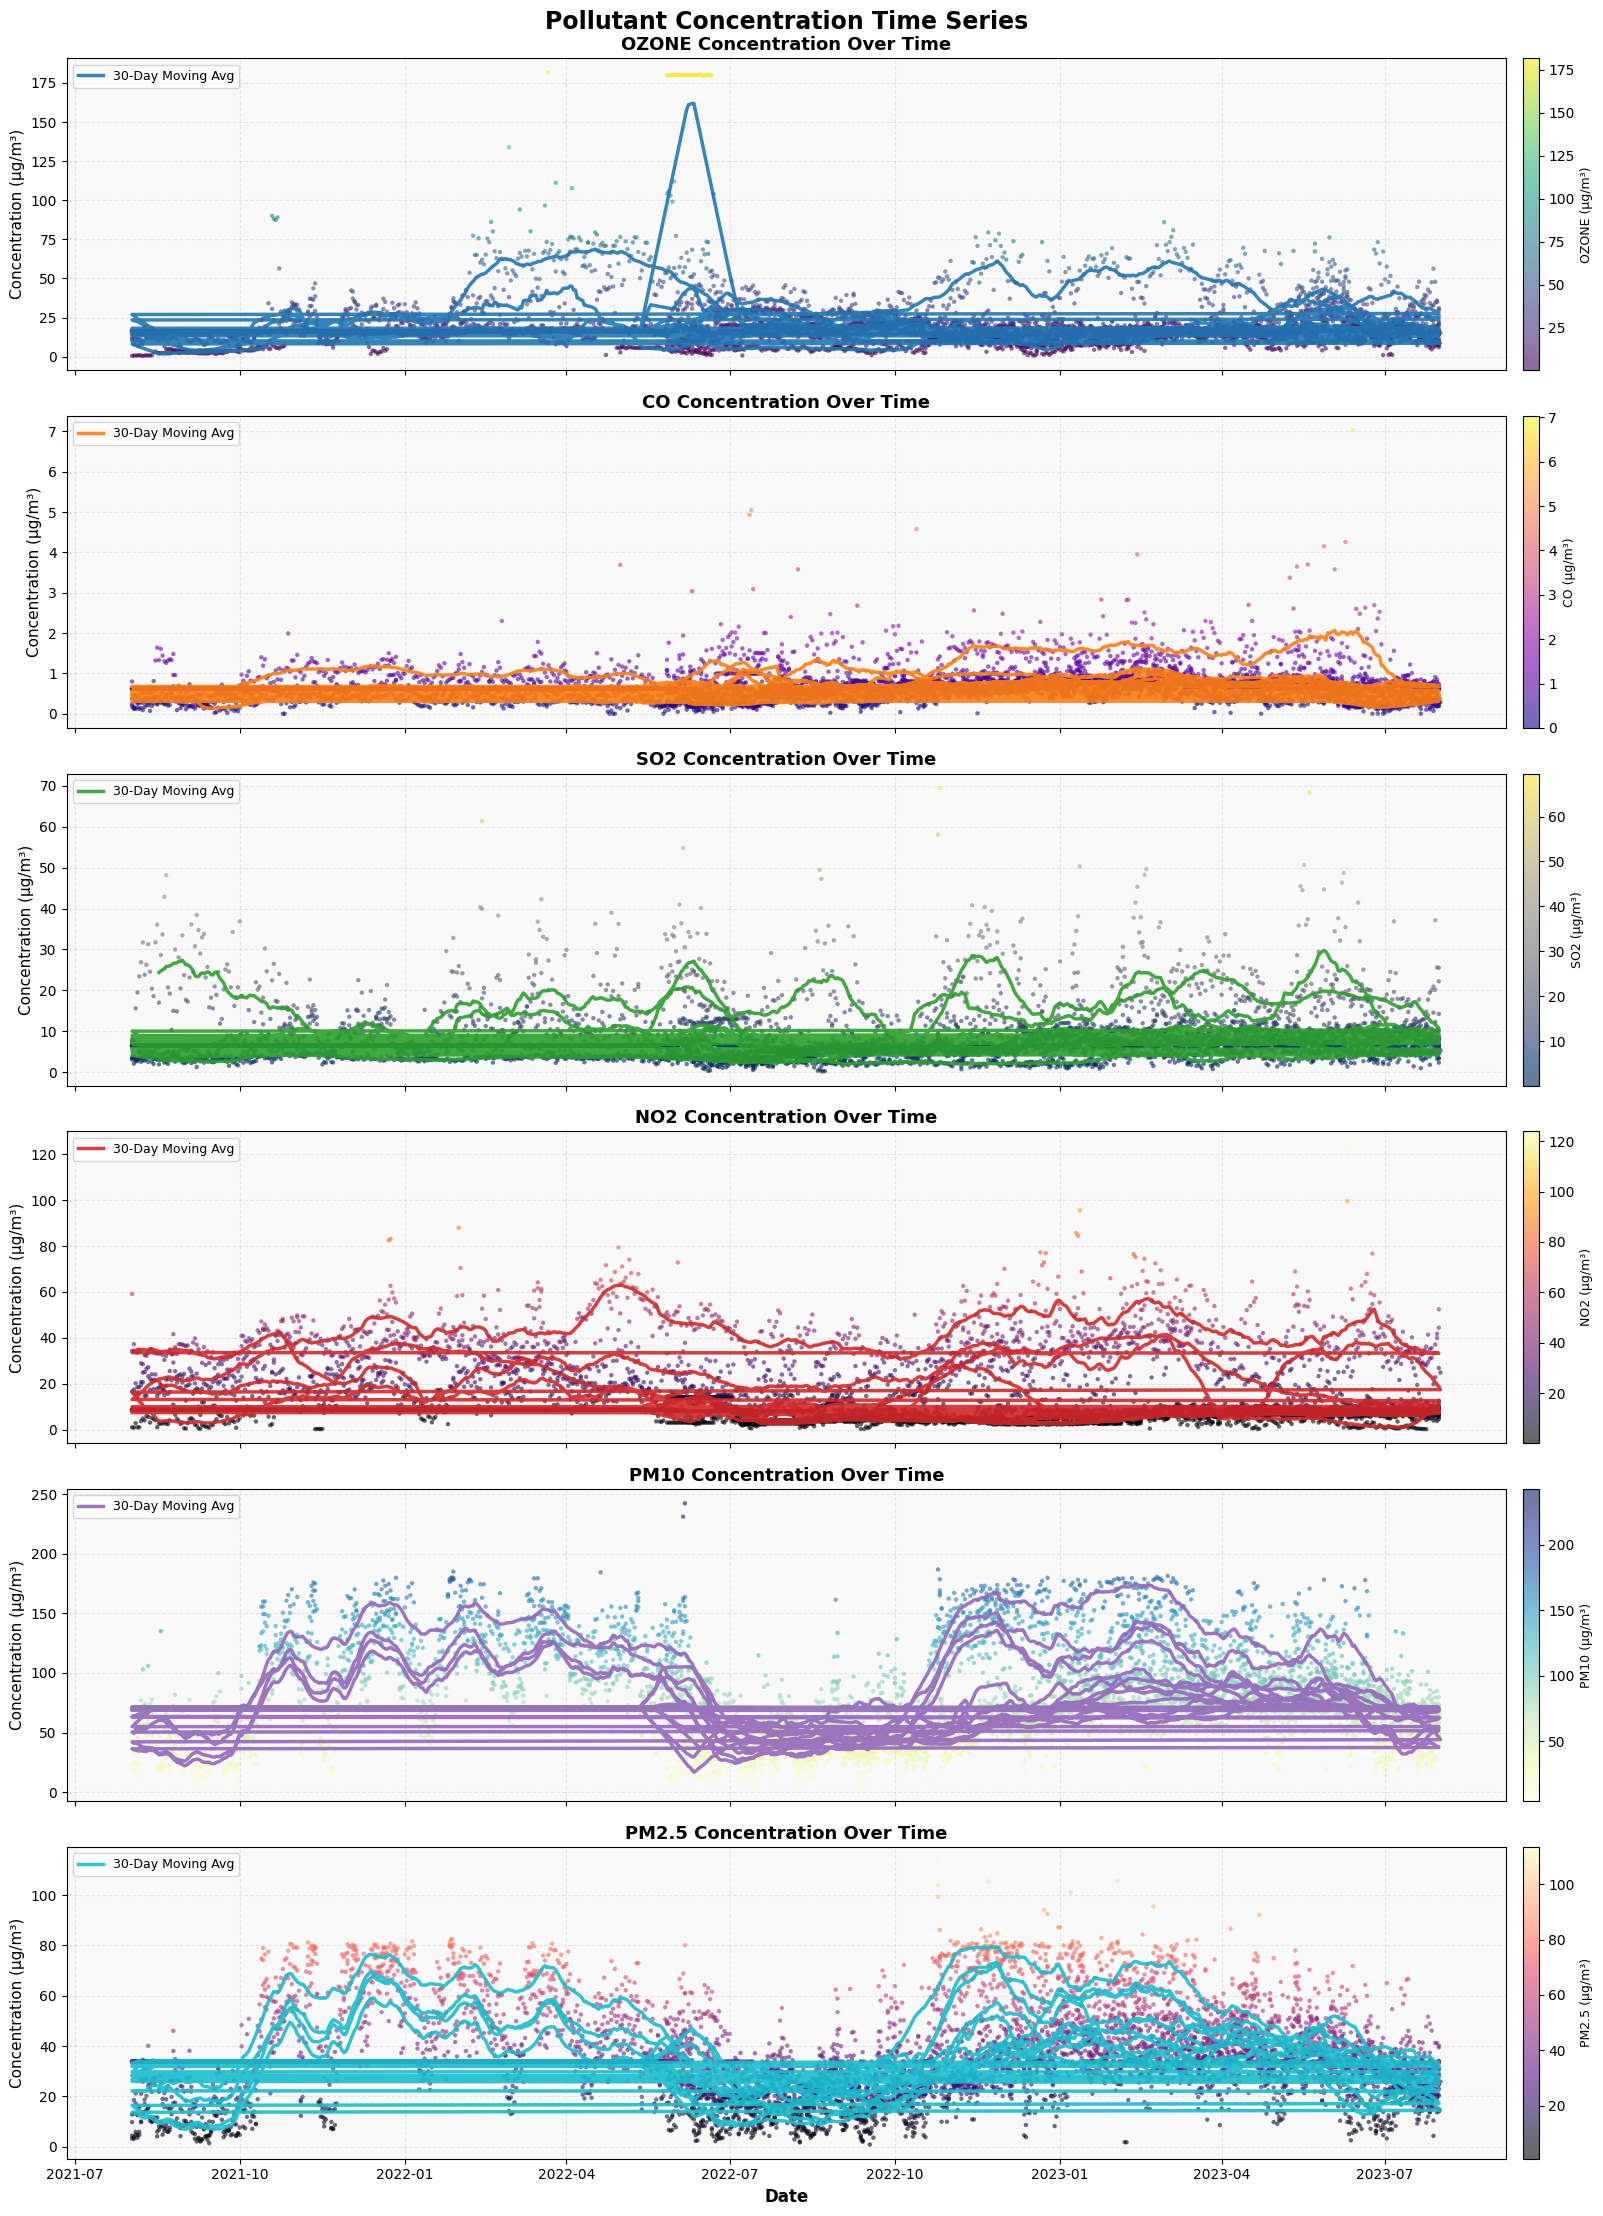

In [411]:
# # Create indexed copy for time series plotting
# df_indexed = df.set_index('to_date')

# fig, axes = plt.subplots(len(pollutants), 1, figsize=(16, 20), sharex=True)

# for i, pollutant in enumerate(pollutants):
#     df_indexed[pollutant].plot(
#         ax=axes[i],
#         marker='.',
#         alpha=0.5,
#         linestyle='None',
#         title=f'{pollutant.upper()} Concentration Over Time',
#         color='steelblue'
#     )
#     axes[i].set_xlabel('Date', fontsize=10)
#     axes[i].set_ylabel('Concentration (μg/m³)', fontsize=10)
#     axes[i].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.suptitle('Pollutant Concentration Time Series', fontsize=16, y=1.001)
# plt.show()



# Create indexed copy for time series plotting
df_indexed = df.set_index('to_date')

fig, axes = plt.subplots(len(pollutants), 1, figsize=(18, 22), sharex=True)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']
# (Blue, Orange, Green, Red, Purple, Teal)

# 'viridis' and 'plasma' are perceptually uniform and colorblind-safe
colormaps = ['viridis', 'plasma', 'cividis', 'inferno', 'YlGnBu', 'magma']

for i, pollutant in enumerate(pollutants):
    data = df_indexed[pollutant]

    # Scatter plot with perceptually uniform colormap
    scatter = axes[i].scatter(
        data.index,
        data,
        c=data,
        cmap=colormaps[i % len(colormaps)],
        alpha=0.6,
        s=10,
        edgecolors='none'
    )

    # 30-day moving average with distinct line color
    moving_avg = data.rolling(window=30, center=True).mean()
    axes[i].plot(
        moving_avg.index,
        moving_avg,
        color=colors[i % len(colors)],
        linewidth=2.5,
        label='30-Day Moving Avg',
        alpha=0.9
    )

    # Colorbar styling
    cbar = plt.colorbar(scatter, ax=axes[i], pad=0.01)
    cbar.set_label(f'{pollutant.upper()} (μg/m³)', fontsize=9)

    # Plot styling
    axes[i].set_title(
        f'{pollutant.upper()} Concentration Over Time',
        fontsize=13,
        fontweight='bold'
    )
    axes[i].set_ylabel('Concentration (μg/m³)', fontsize=11)
    axes[i].grid(True, alpha=0.25, linestyle='--')
    axes[i].legend(loc='upper left', fontsize=9)
    axes[i].set_facecolor('#f9f9f9')

axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.suptitle(
    'Pollutant Concentration Time Series',
    fontsize=17,
    fontweight='bold',
    y=1.005,
    x=0.44
)
plt.show()




# Interactive Time Series Plot (Plotly)

fig = go.Figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

for idx, pollutant in enumerate(pollutants):
    # Add scatter trace
    fig.add_trace(go.Scatter(
        x=df_indexed.index,
        y=df_indexed[pollutant],
        mode='lines',
        name=pollutant.upper(),
        line=dict(width=2, color=colors[idx % len(colors)]),
        opacity=0.7
    ))
    
    # Add 30-day moving average
    # moving_avg = df_indexed[pollutant].rolling(window=30, center=True).mean()
    # fig.add_trace(go.Scatter(
    #     x=moving_avg.index,
    #     y=moving_avg,
    #     mode='lines',
    #     name=f'{pollutant.upper()} - 30D MA',
    #     line=dict(width=3, dash='dash', color=colors[idx % len(colors)]),
    #     opacity=0.9,
    #     visible='legendonly'  # Hidden by default
    # ))

fig.update_layout(
    title='Interactive Pollutant Concentration Over Time',
    xaxis_title='Date',
    yaxis_title='Concentration (μg/m³)',
    hovermode='x unified',
    template='plotly_white',
    height=800,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()

### Top Polluted Cities Analysis

In [402]:
def max_polluted_city(dataframe, pollutant):
    """Get top 10 cities by pollutant concentration."""
    result = dataframe[[pollutant, 'city']].groupby('city').mean().sort_values(
        by=pollutant, ascending=False
    ).reset_index()
    result[pollutant] = round(result[pollutant], 2)
    return result[:10].style.background_gradient(cmap='OrRd')

def display_side_by_side(*args):
    """Display multiple styled DataFrames side-by-side."""
    html_str = ''
    for styled_df in args:
        html_str += styled_df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

# Generate pollutant tables
pm2_5_table = max_polluted_city(df, 'pm2.5')
pm10_table = max_polluted_city(df, 'pm10')
no2_table = max_polluted_city(df, 'no2')
so2_table = max_polluted_city(df, 'so2')
co_table = max_polluted_city(df, 'co')
ozone_table = max_polluted_city(df, 'ozone')

display_side_by_side(pm2_5_table, pm10_table, no2_table, so2_table, co_table, ozone_table)


city 
 pm2.5 
 
 
 
 
 0 
 Hyderabad 
 35.710000 
 
 
 

 
 
 
   
 city 
 pm10 
 
 
 
 
 0 
 Hyderabad 
 76.030000 
 
 
 

 
 
 
   
 city 
 no2 
 
 
 
 
 0 
 Hyderabad 
 13.440000 
 
 
 

 
 
 
   
 city 
 so2 
 
 
 
 
 0 
 Hyderabad 
 7.710000 
 
 
 

 
 
 
   
 city 
 co 
 
 
 
 
 0 
 Hyderabad 
 0.660000 
 
 
 

 
 
 
   
 city 
 ozone 
 
 
 
 
 0 
 Hyderabad 
 18.980000

### Calculate Total Pollution Content and Particulate Matter

In [403]:
df_filled = df.copy()

df_filled['pollution_content'] = df_filled[pollutants].sum(axis=1)

# Particulate Matter Calculation
df_filled['particulate_matter'] = df_filled['pm2.5'] + df_filled['pm10']


### Plot Pollution Content

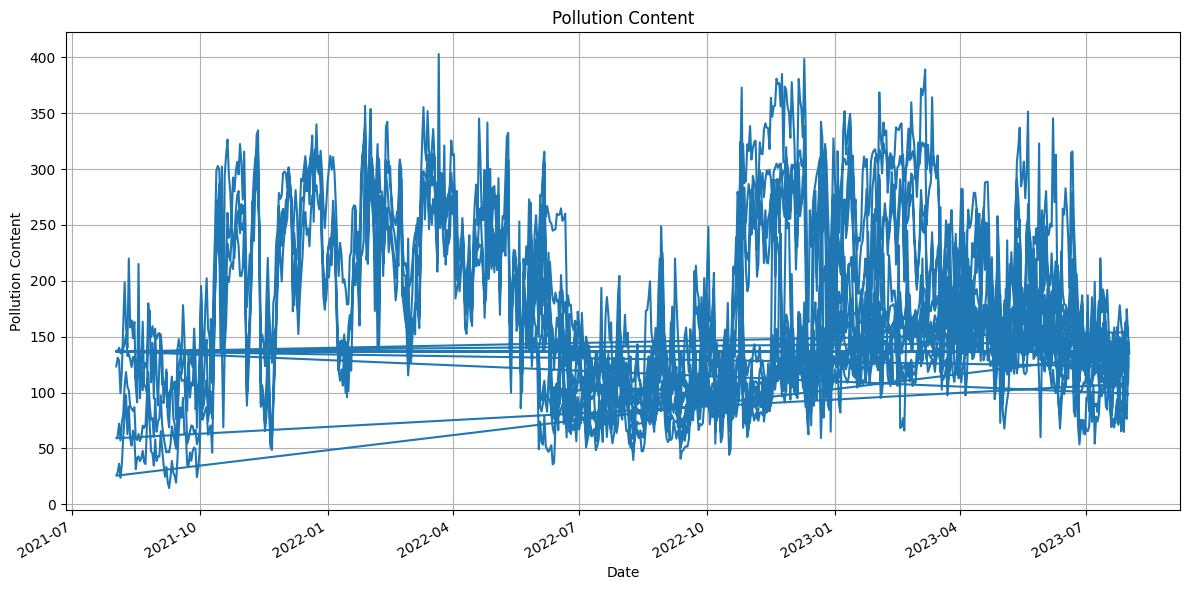

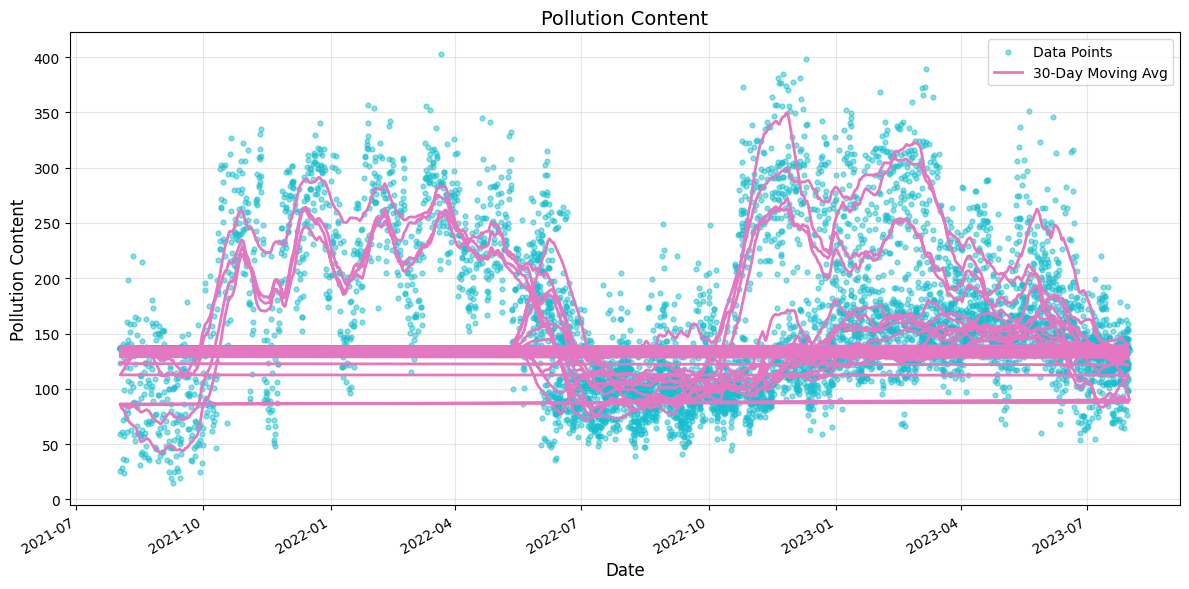

In [404]:
def plot_time_series1(dataframe, variable, date_column='to_date'):
    """Plot time series for a given variable."""
    # Create a copy with date as index if it's not already
    if date_column in dataframe.columns:
        df_plot = dataframe.set_index(date_column)
    else:
        df_plot = dataframe
    
    ax = df_plot[variable].plot(figsize=(12, 6), title=variable.replace('_', ' ').title())
    ax.set_xlabel('Date')
    ax.set_ylabel(variable.replace('_', ' ').title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_time_series1(df_filled, 'pollution_content')



def plot_time_series2(dataframe, variable, date_column='to_date'):
    """Plot time series for a given variable."""
    # Create a copy with date as index if it's not already
    if date_column in dataframe.columns:
        df_plot = dataframe.set_index(date_column)
    else:
        df_plot = dataframe
    
    # Scatter plot instead of line plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(df_plot.index, df_plot[variable], alpha=0.5, s=12, color='#17becf', label='Data Points')

    # Optional: Add moving average trend line
    df_plot[variable].rolling(window=30, center=True).mean().plot(
        ax=ax, color='#e377c2', linewidth=2, label='30-Day Moving Avg'
    )
    
    ax.set_title(variable.replace('_', ' ').title(), fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(variable.replace('_', ' ').title(), fontsize=12)
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_time_series2(df_filled, 'pollution_content')

### AQI Calculation Functions

In [405]:
# NAQI Breakpoints (India)
breakpoints = {
    'pm2.5': [(0, 50, 0, 30), (51, 100, 31, 60), (101, 200, 61, 90), 
              (201, 300, 91, 120), (301, 400, 121, 250), (401, 500, 251, 500)],
    'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 200, 101, 250), 
             (201, 300, 251, 350), (301, 400, 351, 430), (401, 500, 431, 500)],
    'no2': [(0, 50, 0, 40), (51, 100, 41, 80), (101, 200, 81, 180), 
            (201, 300, 181, 280), (301, 400, 281, 400), (401, 500, 401, 500)],
    'ozone': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 200, 101, 168), 
              (201, 300, 169, 208), (301, 400, 209, 748), (401, 500, 749, 1000)],
    'co': [(0, 50, 0, 1.0), (51, 100, 1.1, 2.0), (101, 200, 2.1, 10), 
           (201, 300, 10.1, 17), (301, 400, 17.1, 34), (401, 500, 34.1, 50)],
    'so2': [(0, 50, 0, 40), (51, 100, 41, 80), (101, 200, 81, 380), 
            (201, 300, 381, 800), (301, 400, 801, 1600), (401, 500, 1601, 2000)]
}

def get_aqi_sub_index(concentration, pollutant):
    """Calculate AQI sub-index using linear interpolation."""
    if pd.isna(concentration) or concentration < 0:
        return np.nan
    
    for i_lo, i_hi, b_lo, b_hi in breakpoints[pollutant]:
        if b_lo <= concentration <= b_hi:
            if b_hi == b_lo:
                return i_lo
            return round(((i_hi - i_lo) / (b_hi - b_lo)) * (concentration - b_lo) + i_lo)
    
    # Cap at 500 if above highest breakpoint
    if concentration > breakpoints[pollutant][-1][3]:
        return 500
    
    return np.nan

def calculate_aqi(row):
    """Calculate overall AQI (maximum of all sub-indices)."""
    sub_indices = [get_aqi_sub_index(row[p], p) for p in pollutants]
    return np.nanmax(sub_indices) if any(~np.isnan(sub_indices)) else np.nan

def get_aqi_category(aqi):
    """Assign AQI category."""
    if pd.isna(aqi):
        return np.nan
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 200:
        return 'Moderate'
    else:
        return 'Severe'

# Apply AQI calculations
df['aqi'] = df.apply(calculate_aqi, axis=1)
df['aqi_category'] = df['aqi'].apply(get_aqi_category)

print(df[['pm2.5', 'pm10', 'aqi', 'aqi_category']].head())

   pm2.5   pm10   aqi aqi_category
0   9.76  35.24  74.0     Moderate
1  18.54  59.63  60.0     Moderate
2  21.17  64.41  64.0     Moderate
3  12.65  45.94  46.0         Good
4  16.21  56.57  57.0     Moderate


### Correlation Analysis

In [406]:
# Prepare data for correlation analysis
df_corr = df.copy()
df_corr = df_corr.drop(columns=['from_date', 'to_date', 'state', 'city', 'station', 'aqi_category'], errors='ignore')

# Select only numeric columns for correlation
num_df = df_corr.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = num_df.corr()

# Plot heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Feature Correlation Heatmap", fontsize=14)
# plt.tight_layout()
# plt.show()

# Interactive Correlation Heatmap
fig = px.imshow(
    corr_matrix,
    text_auto='.2f',
    color_continuous_scale='RdBu_r',
    title='Interactive Correlation Heatmap',
    labels=dict(color="Correlation"),
    aspect='auto'
)

fig.update_layout(
    height=700,
    title_font_size=18
)

fig.show()

### Multi-Model Training and Evaluation (Linear Regression, Random Forest, XGBoost, CatBoost)

#### For AQI Prediction (4 Models)

In [407]:
# Prepare data for AQI prediction models
df_aqi_model = df.copy()
df_aqi_model = df_aqi_model.dropna(subset=['aqi'])

# Define features and target for AQI prediction
features = ['ozone', 'co', 'so2', 'no2', 'pm10', 'pm2.5']
target = 'aqi'

X_aqi = df_aqi_model[features].fillna(df_aqi_model[features].median())
y_aqi = df_aqi_model[target]

# Train-Test Split
X_train_aqi, X_test_aqi, y_train_aqi, y_test_aqi = train_test_split(
    X_aqi, y_aqi, test_size=0.2, random_state=42
)

# Add Gaussian noise to training data for robustness
noise_factor = 0.03
noise = noise_factor * X_train_aqi.std().values * np.random.randn(*X_train_aqi.shape)
X_train_aqi_noisy = X_train_aqi + noise

# Feature Scaling (required for Linear Regression & XGBoost)
scaler = StandardScaler()
X_train_aqi_scaled = scaler.fit_transform(X_train_aqi_noisy)
X_test_aqi_scaled = scaler.transform(X_test_aqi)

# Initialize All 4 Models
models_aqi = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False
    )
}

# Train, Predict & Evaluate All Models
results_aqi = []

for name, model in models_aqi.items():
    print(f"\nTraining {name} for AQI prediction...")
    
    # Use scaled data for Linear Regression/XGBoost, unscaled for tree-based models
    if name in ["Linear Regression", "XGBoost"]:
        X_train_use = X_train_aqi_scaled
        X_test_use = X_test_aqi_scaled
    else:
        X_train_use = X_train_aqi_noisy
        X_test_use = X_test_aqi
    
    # Train model
    model.fit(X_train_use, y_train_aqi)
    
    # Predict
    y_pred_aqi = model.predict(X_test_use)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_aqi, y_pred_aqi)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_aqi, y_pred_aqi)
    r2 = r2_score(y_test_aqi, y_pred_aqi)
    
    results_aqi.append({
        "Model": name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    })
    
    print(f"{name} — R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Convert to DataFrame
results_aqi_df = pd.DataFrame(results_aqi)

print("\n" + "="*70)
print("AQI PREDICTION MODEL COMPARISON (4 MODELS)")
print("="*70)
print(results_aqi_df.to_string(index=False))
print("="*70)


Training Linear Regression for AQI prediction...
Linear Regression — R²: 0.8499, RMSE: 11.9096, MAE: 5.9483

Training Random Forest for AQI prediction...
Random Forest — R²: 0.9895, RMSE: 3.1549, MAE: 0.8197

Training XGBoost for AQI prediction...
XGBoost — R²: 0.9827, RMSE: 4.0391, MAE: 1.1935

Training CatBoost for AQI prediction...
CatBoost — R²: 0.9844, RMSE: 3.8377, MAE: 1.3503

AQI PREDICTION MODEL COMPARISON (4 MODELS)
            Model      MSE    RMSE    MAE     R²
Linear Regression 141.8389 11.9096 5.9483 0.8499
    Random Forest   9.9531  3.1549 0.8197 0.9895
          XGBoost  16.3145  4.0391 1.1935 0.9827
         CatBoost  14.7281  3.8377 1.3503 0.9844


#### For Individual Pollutants (4 Models)

In [408]:
pollutants = ['ozone', 'co', 'so2', 'no2', 'pm10', 'pm2.5']

# Prepare data
df_model = df.copy()

# Drop non-numeric columns BEFORE splitting
df_model = df_model.drop(columns=['from_date', 'to_date', 'state', 'city', 'station', 'aqi_category'], errors='ignore')

# Select only numeric columns
df_model = df_model.select_dtypes(include=['number'])

# Drop rows with missing values
df_model = df_model.dropna()

# Store all results
all_pollutant_results = {}

# Train models for each pollutant
for pollutant in pollutants:
    print(f"\n{'='*70}")
    print(f"TRAINING MODELS FOR {pollutant.upper()}")
    print('='*70)
    
    # Features and target
    X = df_model.drop(columns=pollutants)
    y = df_model[pollutant]
    
    # Verify X contains only numeric data
    print(f"  Features: {X.columns.tolist()}")
    print(f"  X shape: {X.shape}, y shape: {y.shape}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Feature scaling (now safe - only numeric columns)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
        "CatBoost": CatBoostRegressor(
            iterations=500,
            learning_rate=0.05,
            depth=8,
            l2_leaf_reg=3,
            random_seed=42,
            verbose=False
        )
    }
    
    pollutant_results = []
    
    for name, model in models.items():
        # Use scaled data for Linear Regression/XGBoost
        if name in ["Linear Regression", "XGBoost"]:
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test
        
        # Train
        model.fit(X_train_use, y_train)
        y_pred = model.predict(X_test_use)
        
        # Metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        pollutant_results.append({
            "Model": name,
            "R²": round(r2, 4),
            "RMSE": round(rmse, 4),
            "MAE": round(mae, 4)
        })
        
        print(f"  {name:20s} — R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    all_pollutant_results[pollutant] = pd.DataFrame(pollutant_results)



TRAINING MODELS FOR OZONE
  Features: ['aqi']
  X shape: (8760, 1), y shape: (8760,)
  Linear Regression    — R²: 0.1214, RMSE: 14.1334, MAE: 7.2258
  Random Forest        — R²: 0.3384, RMSE: 12.2643, MAE: 6.1891
  XGBoost              — R²: 0.3428, RMSE: 12.2233, MAE: 6.1682
  CatBoost             — R²: 0.3497, RMSE: 12.1592, MAE: 6.1430

TRAINING MODELS FOR CO
  Features: ['aqi']
  X shape: (8760, 1), y shape: (8760,)
  Linear Regression    — R²: 0.1228, RMSE: 0.3150, MAE: 0.1790
  Random Forest        — R²: 0.1532, RMSE: 0.3095, MAE: 0.1722
  XGBoost              — R²: 0.1593, RMSE: 0.3084, MAE: 0.1710
  CatBoost             — R²: 0.1654, RMSE: 0.3072, MAE: 0.1703

TRAINING MODELS FOR SO2
  Features: ['aqi']
  X shape: (8760, 1), y shape: (8760,)
  Linear Regression    — R²: 0.0566, RMSE: 5.1415, MAE: 2.8944
  Random Forest        — R²: 0.1222, RMSE: 4.9595, MAE: 2.5952
  XGBoost              — R²: 0.1260, RMSE: 4.9488, MAE: 2.5917
  CatBoost             — R²: 0.1319, RMSE: 4.9319,

### Multi-Model Performance Visualization

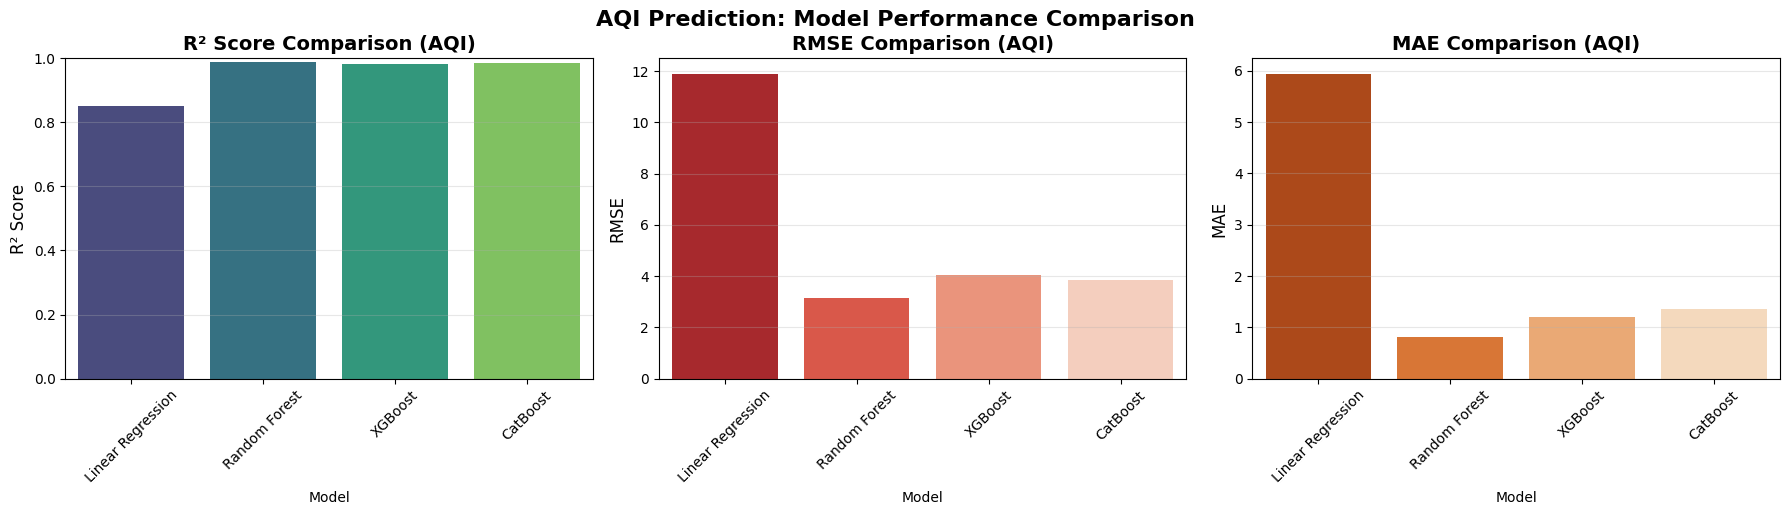

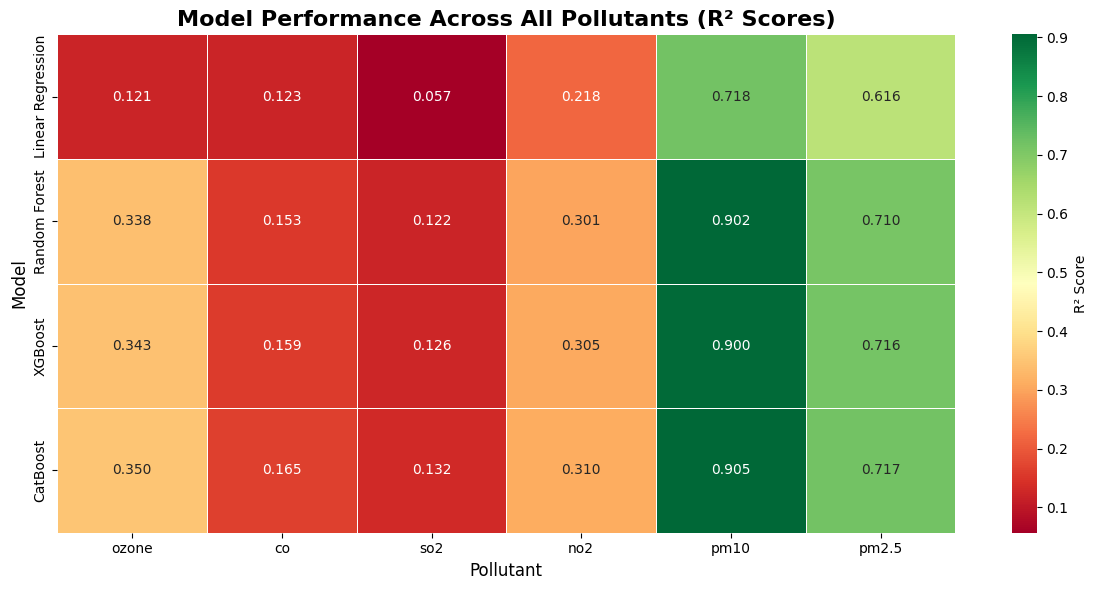

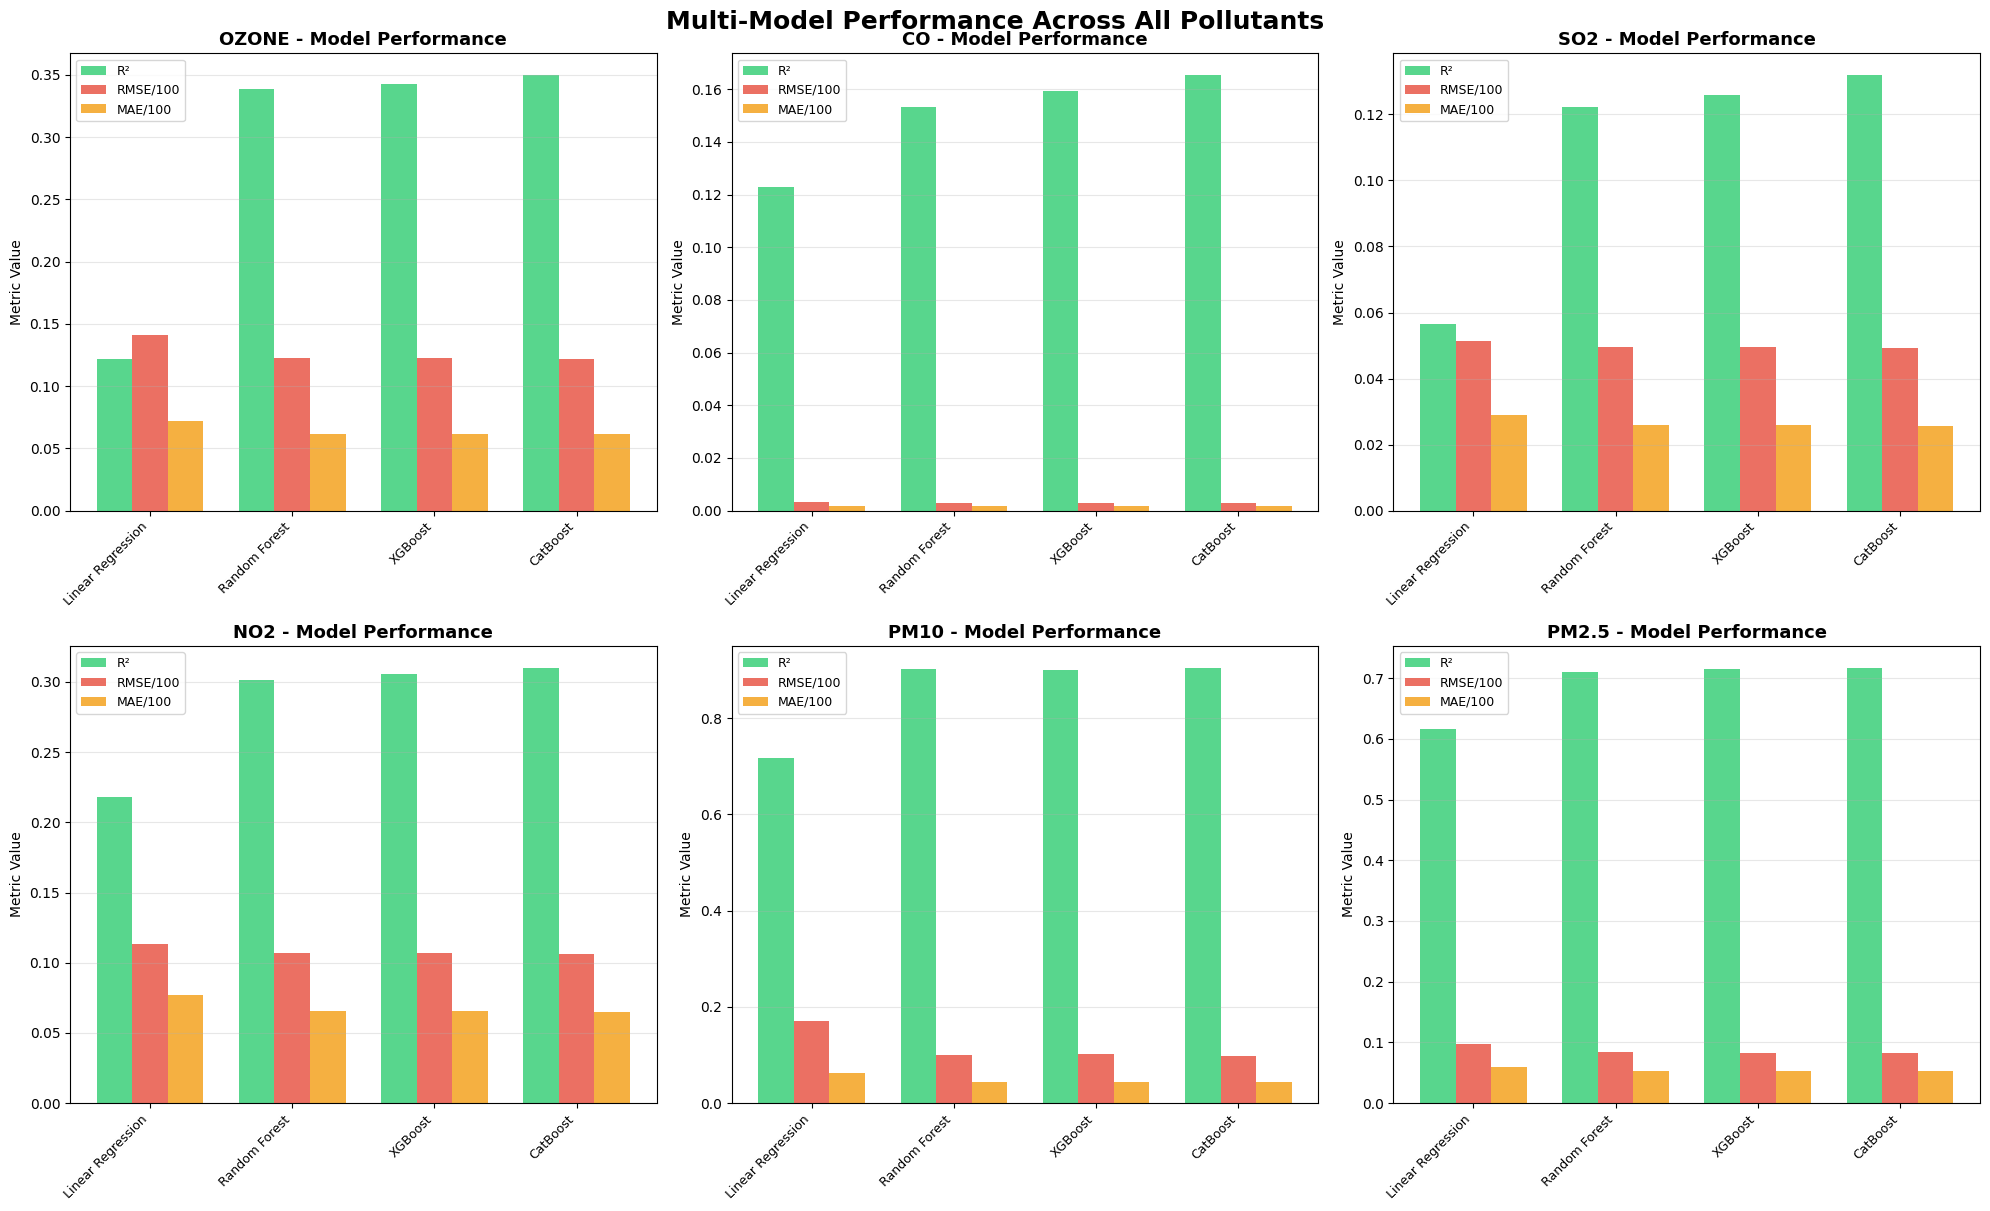


BEST MODEL FOR AQI PREDICTION
Model:        Random Forest
R² Score:     0.9895
RMSE:         3.1549
MAE:          0.8197

BEST MODELS PER POLLUTANT
OZONE      → CatBoost             (R²: 0.3497)
CO         → CatBoost             (R²: 0.1654)
SO2        → CatBoost             (R²: 0.1319)
NO2        → CatBoost             (R²: 0.3102)
PM10       → CatBoost             (R²: 0.9053)
PM2.5      → CatBoost             (R²: 0.7173)


In [409]:
# ========== 1. AQI Prediction Model Comparison ==========

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Comparison
sns.barplot(data=results_aqi_df, x='Model', y='R²', hue='Model', palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('R² Score Comparison (AQI)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# RMSE Comparison
sns.barplot(data=results_aqi_df, x='Model', y='RMSE', hue='Model', palette='Reds_r', legend=False, ax=axes[1])
axes[1].set_title('RMSE Comparison (AQI)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# MAE Comparison
sns.barplot(data=results_aqi_df, x='Model', y='MAE', hue='Model', palette='Oranges_r', legend=False, ax=axes[2])
axes[2].set_title('MAE Comparison (AQI)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('AQI Prediction: Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()


# ========== 2.1 Pollutant-wise Model Performance Heatmap ==========

# Combine all pollutant results
combined_metrics = {}
for pollutant, df_results in all_pollutant_results.items():
    for _, row in df_results.iterrows():
        model_name = row['Model']
        if model_name not in combined_metrics:
            combined_metrics[model_name] = {}
        combined_metrics[model_name][pollutant] = row['R²']

# Create DataFrame for heatmap
heatmap_df = pd.DataFrame(combined_metrics).T

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    heatmap_df, 
    annot=True, 
    fmt='.3f', 
    cmap='RdYlGn', 
    linewidths=0.5,
    cbar_kws={'label': 'R² Score'},
    ax=ax
)
ax.set_title('Model Performance Across All Pollutants (R² Scores)', fontsize=16, fontweight='bold')
ax.set_xlabel('Pollutant', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()

# ========= 2.2 =========
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
for idx, pollutant in enumerate(pollutants):
    df_plot = all_pollutant_results[pollutant]
    # Plot grouped bars
    x = np.arange(len(df_plot))
    width = 0.25
    axes[idx].bar(x - width, df_plot['R²'], width, label='R²', color='#2ecc71', alpha=0.8)
    axes[idx].bar(x, df_plot['RMSE']/100, width, label='RMSE/100', color='#e74c3c', alpha=0.8)
    axes[idx].bar(x + width, df_plot['MAE']/100, width, label='MAE/100', color='#f39c12', alpha=0.8)
    axes[idx].set_title(f'{pollutant.upper()} - Model Performance', fontsize=13, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(df_plot['Model'], rotation=45, ha='right', fontsize=9)
    axes[idx].set_ylabel('Metric Value', fontsize=10)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.suptitle('Multi-Model Performance Across All Pollutants', fontsize=18, fontweight='bold', y=1.005)
plt.show()


# ========== 3. Styled Results Tables ==========

# AQI Results
styled_aqi = results_aqi_df.style.background_gradient(
    cmap='RdYlGn', subset=['R²']
).background_gradient(
    cmap='RdYlGn_r', subset=['RMSE', 'MAE']
).set_caption("AQI Prediction: 4-Model Comparison")

display(styled_aqi)

# Pollutant Results 
for pollutant in ['ozone', 'co', 'so2', 'no2', 'pm10', 'pm2.5']:
    styled_poll = all_pollutant_results[pollutant].style.background_gradient(
        cmap='RdYlGn', subset=['R²']
    ).background_gradient(
        cmap='RdYlGn_r', subset=['RMSE', 'MAE']
    ).set_caption(f"{pollutant.upper()} Prediction: 4-Model Comparison")
    
    display(styled_poll)


# ========== 4. Best Model Identification ==========

best_model_aqi = results_aqi_df.sort_values(by='R²', ascending=False).iloc[0]

print("\nBEST MODEL FOR AQI PREDICTION")
print("="*70)
print(f"Model:        {best_model_aqi['Model']}")
print(f"R² Score:     {best_model_aqi['R²']:.4f}")
print(f"RMSE:         {best_model_aqi['RMSE']:.4f}")
print(f"MAE:          {best_model_aqi['MAE']:.4f}")
print("="*70)

# Best model per pollutant
print("\nBEST MODELS PER POLLUTANT")
print("="*70)
for pollutant, df_results in all_pollutant_results.items():
    best_row = df_results.sort_values(by='R²', ascending=False).iloc[0]
    print(f"{pollutant.upper():10s} → {best_row['Model']:20s} (R²: {best_row['R²']:.4f})")
print("="*70)

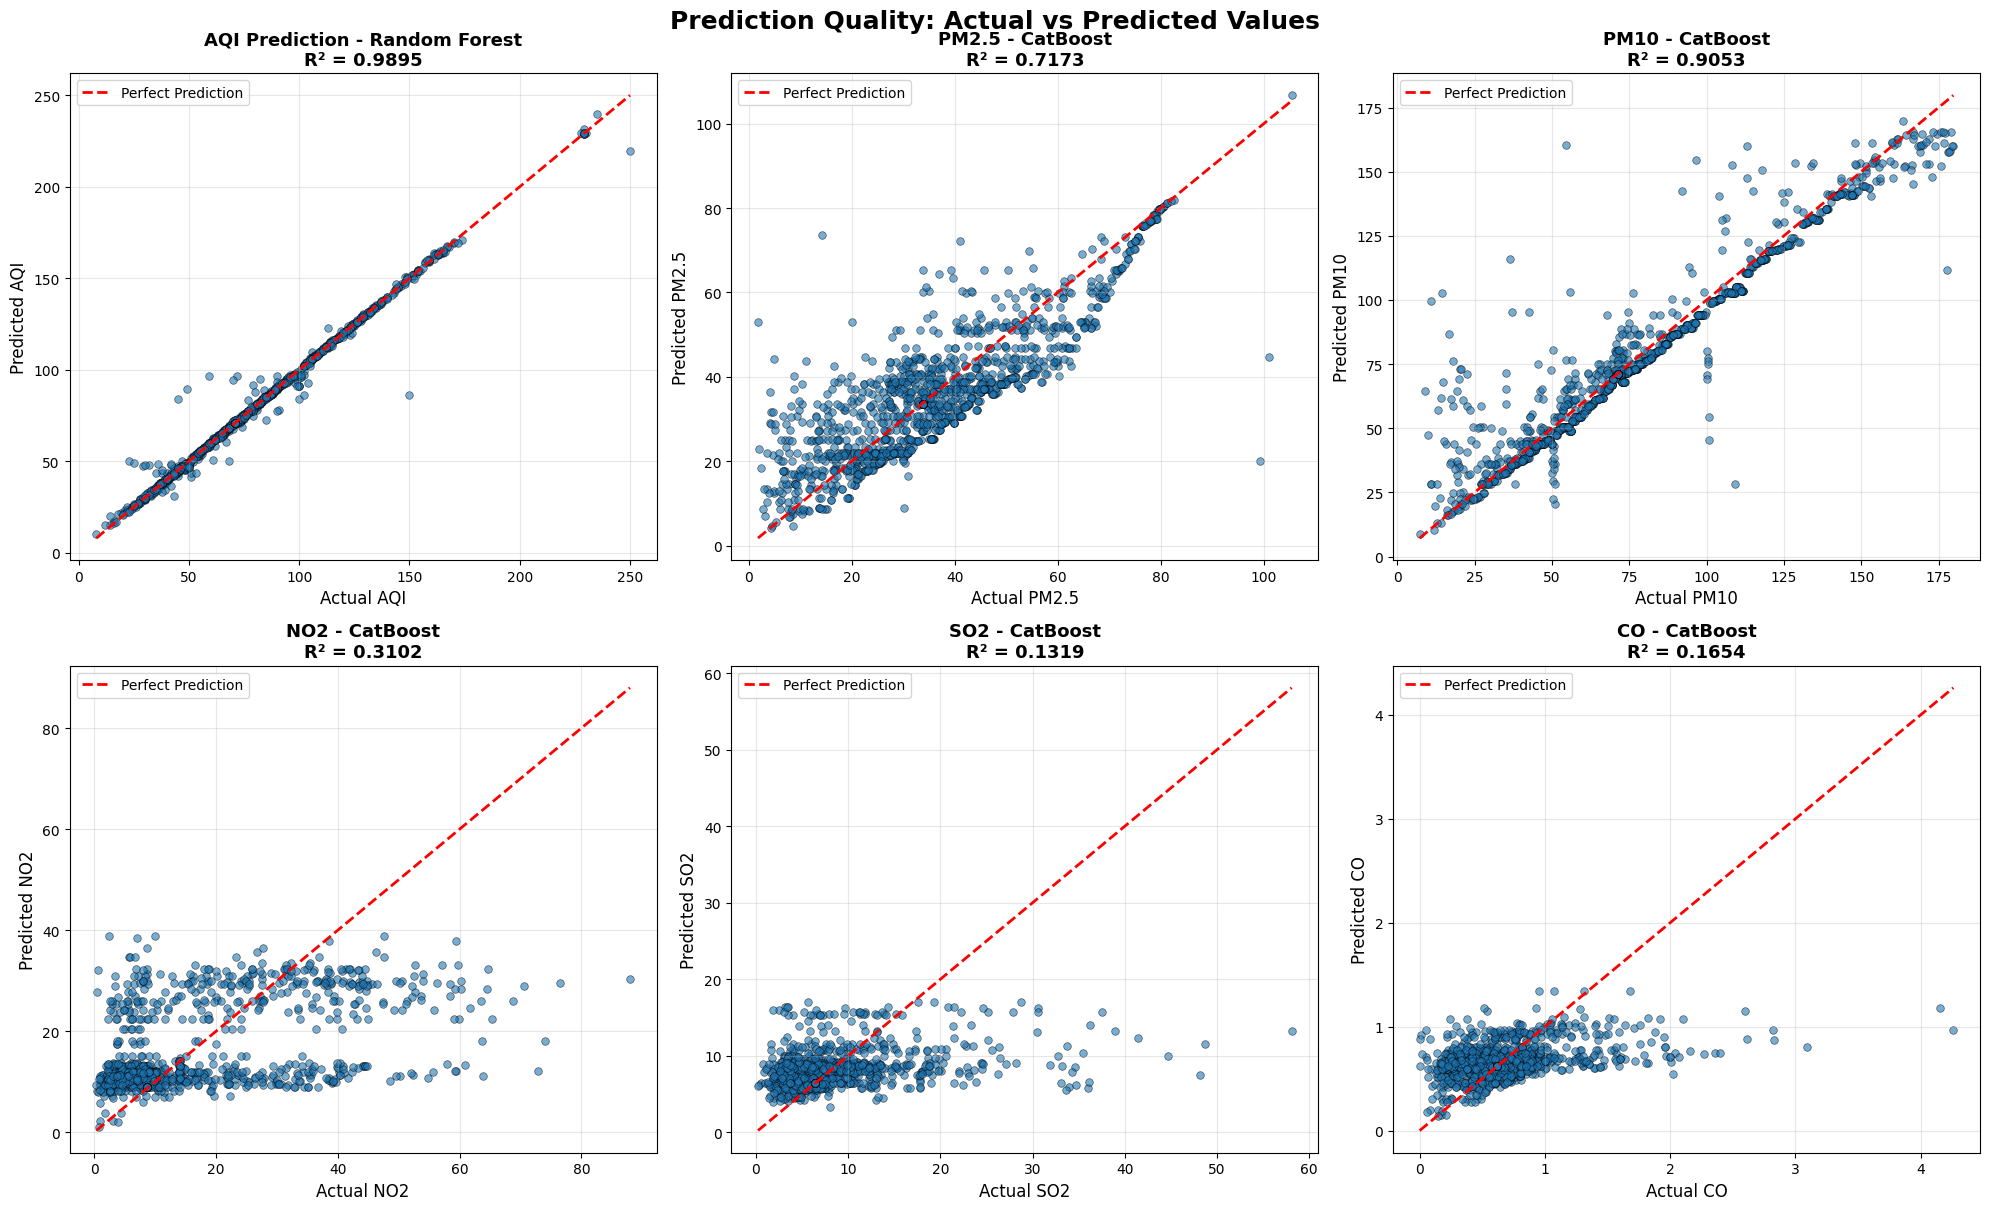

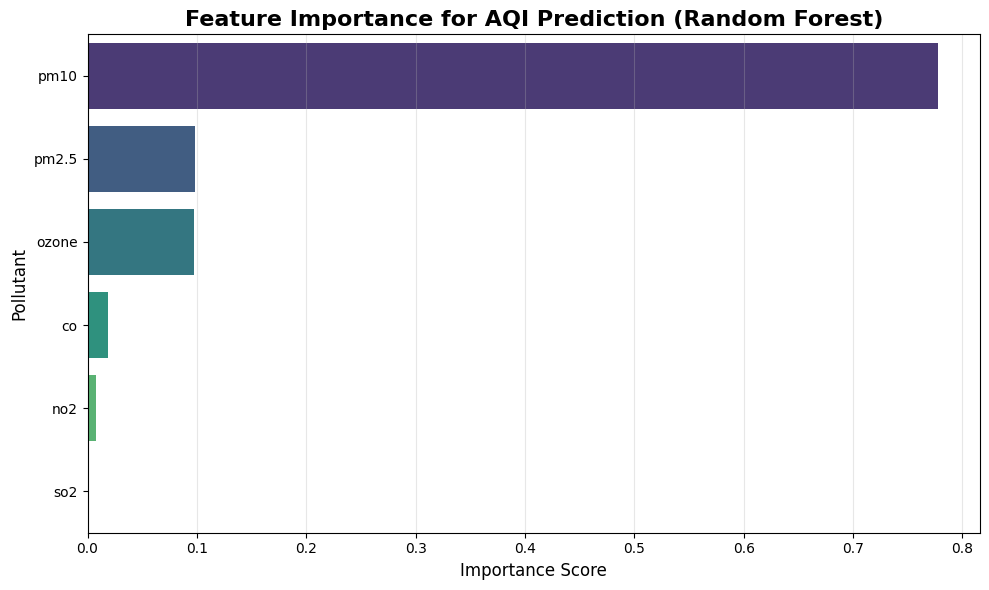

In [410]:
### Prediction Quality Assessment: Actual vs Predicted

# For AQI - Best Model
best_model_name = results_aqi_df.sort_values(by='R²', ascending=False).iloc[0]['Model']
best_model_aqi = models_aqi[best_model_name]

# Get predictions
if best_model_name in ["Linear Regression", "XGBoost"]:
    y_pred_best = best_model_aqi.predict(X_test_aqi_scaled)
else:
    y_pred_best = best_model_aqi.predict(X_test_aqi)

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# AQI prediction plot
axes[0].scatter(y_test_aqi, y_pred_best, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test_aqi.min(), y_test_aqi.max()], 
             [y_test_aqi.min(), y_test_aqi.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual AQI', fontsize=12)
axes[0].set_ylabel('Predicted AQI', fontsize=12)
axes[0].set_title(f'AQI Prediction - {best_model_name}\nR² = {r2_score(y_test_aqi, y_pred_best):.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Pollutant predictions
for idx, pollutant in enumerate(['pm2.5', 'pm10', 'no2', 'so2', 'co'], start=1):
    best_pollutant_model = all_pollutant_results[pollutant].sort_values(by='R²', ascending=False).iloc[0]['Model']
    
    # Retrain to get predictions (simplified - you can optimize this)
    X = df_model.drop(columns=pollutants)
    y = df_model[pollutant]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if best_pollutant_model == "Linear Regression":
        model_temp = LinearRegression()
        scaler_temp = StandardScaler()
        X_test_scaled = scaler_temp.fit_transform(X_train)
        model_temp.fit(X_test_scaled, y_train)
        y_pred = model_temp.predict(scaler_temp.transform(X_test))
    elif best_pollutant_model == "XGBoost":
        model_temp = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        scaler_temp = StandardScaler()
        X_test_scaled = scaler_temp.fit_transform(X_train)
        model_temp.fit(X_test_scaled, y_train)
        y_pred = model_temp.predict(scaler_temp.transform(X_test))
    else:
        if best_pollutant_model == "Random Forest":
            model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
        else:  # CatBoost
            model_temp = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=8, 
                                          l2_leaf_reg=3, random_seed=42, verbose=False)
        model_temp.fit(X_train, y_train)
        y_pred = model_temp.predict(X_test)
    
    # Plot
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], 
                   [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel(f'Actual {pollutant.upper()}', fontsize=12)
    axes[idx].set_ylabel(f'Predicted {pollutant.upper()}', fontsize=12)
    axes[idx].set_title(f'{pollutant.upper()} - {best_pollutant_model}\nR² = {r2_score(y_test, y_pred):.4f}', 
                        fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Prediction Quality: Actual vs Predicted Values', fontsize=18, fontweight='bold', y=1.005)
plt.show()


### Feature Importance Analysis

# Random Forest for AQI
rf_model_aqi = models_aqi["Random Forest"]
feature_importance_aqi = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model_aqi.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance_aqi, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False, ax=ax)
ax.set_title('Feature Importance for AQI Prediction (Random Forest)', fontsize=16, fontweight='bold')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Pollutant', fontsize=12)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()